(50000, 32, 32)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


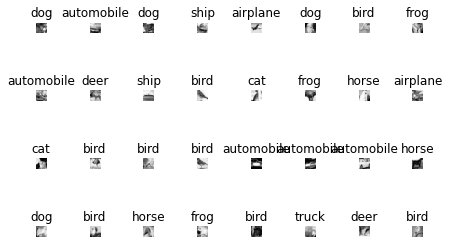

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import random

# 设置随机种子
random.seed(1)

# 第一步：构造unpick用于读取数据
def unpickle(filename):
    # 打开文件，二进制格式
    f = open(filename, 'rb')
    # 文件的载入，编码方式为'latin1'
    out = pickle.load(f, encoding='latin1')
    f.close()
    return out
# 第二步：对图片进行预处理，灰度化，裁剪，标准化
def clean(data):
    # 图像的维度转换
    data_reshaped = data.reshape(-1, 3, 32, 32)
    # 进行灰度化处理
    gray_img = data_reshaped.mean(1)
    print(gray_img.shape)
    # 对图像进行裁剪
    gray_img_crop = gray_img[:, 4:28, 4:28]
    # 将图像的维度转换为原来的二维数据
    gray_img_crop = gray_img_crop.reshape([len(gray_img_crop), -1])
    # 求得图像的均值
    mean = np.mean(gray_img_crop, axis=1)
    # 将均值的维度转换为2维，以便用于后续的相减操作
    meanT = mean.reshape([len(mean), 1])
    # 求得图像的标准差
    std = np.std(gray_img_crop, axis=1)
    # 将标准差转换为2维形式
    stdT = std.reshape([len(std), 1])
    # 如果标准差过大，使用1/np.sqrt(len(stdT)代替)
    adj_std = np.maximum(stdT, 1/np.sqrt(len(stdT)))
    # 进行标准化操作
    normalize = (gray_img_crop - meanT) / adj_std

    return normalize


# 第三步：数据的载入
def load_data(filename):
    # 数据标签名的读入
    names = unpickle('{}/batches.meta'.format(filename))['label_names']
    data = []
    labels = []
    for i in range(1, 6):
        # 循环读取，每一个文件的数据和标签名
        data_dict = unpickle('{}/data_batch_{}'.format(filename, i))
        if len(data) > 0 :
            # 对数据进行竖着串接
            data = np.vstack((data, data_dict['data']))
            # 对标签进行横着串接
            labels = np.hstack((labels, data_dict['labels']))
        else:
            data = data_dict['data']
            labels = data_dict['labels']
    # 对数据进行预处理操作
    data = clean(data)
    # 将数据的类型转换为np.float32
    data = data.astype(np.float32)
    # 返回标签名，数据，标签
    return names, data, labels

names, data, labels = load_data('./cifar10_data/cifar-10-batches-py')
print(names)
# 第四步：进行图像的随机展示
def show_random_img(names, data, labels):
    # 数据的大小
    N = data.shape[0]
    # 横和列的个数
    rows, cols = 4, 8
    # 从N个数据列表中，随机挑选4*8个数据的索引值
    randix = random.sample(range(N), rows*cols)
    plt.figure()
    for i in range(rows * cols):
        # 循环，构造每一个图的子图
        plt.subplot(rows, cols, i+1)
        # 获得单个的索引值
        j = randix[i]
        # 文章名 ，使用标签对应的类别名
        plt.title(names[labels[j]])
        # 图像的维度转换
        img = data[j,:].reshape([24, 24])
        # 图片的展示
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_img(names, data, labels)

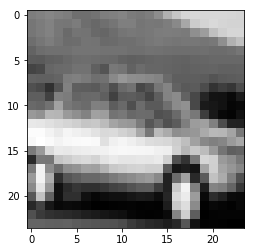

conv:


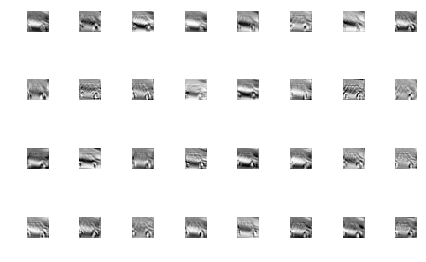

w:


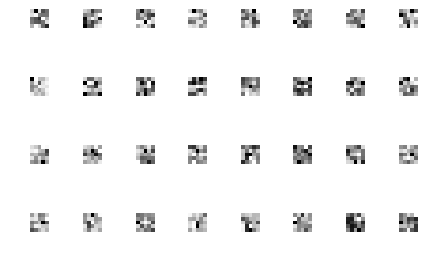

conv_out


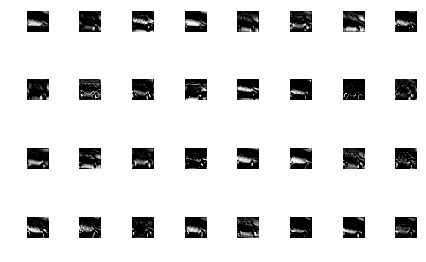

pool


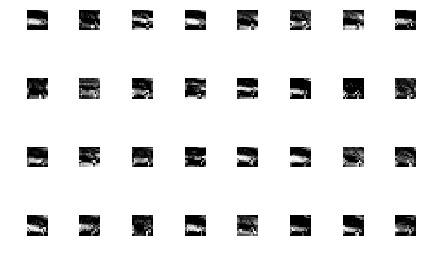

In [2]:
# 第二部分：进行卷积过程中的图像展示
# 第一步：随机选择一张图，进行卷积图和参数图的演示
row_img = data[4,:]
# 图像维度的变化
row_img = row_img.reshape([24, 24])
plt.figure()
plt.imshow(row_img, cmap='Greys_r')
plt.show()
# 第二步：将图片进行维度变换，构造参数，并进行卷积，激活和池化操作
x = tf.reshape(row_img, shape=[-1, 24, 24, 1])
# 卷积的维度为[5, 5, 1, 32] 5和5表示维度，1表示通道数，32表示filter个数
W1 = tf.Variable(tf.random_normal([5, 5, 1, 32]))
# 构造b1参数，维度为[32]
b1 = tf.Variable(tf.random_normal([32]))
# 进行一次卷积操作，strides表示步长
conv = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')
# 加上偏置项b
conv_with_b = tf.add(conv, b1)
# 使用激活函数进行激活
conv_out = tf.nn.relu(conv_with_b)

# 池化操作
k = 2
max_pool = tf.nn.max_pool(conv_out, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

# 第三步：构造函数，进行卷积过程中的图像展示
def show_conv_img(conv_out, filename=None):
    # rows，cols的大小
    rows, cols = 4, 8
    # 循环，卷积图像的通道数
    for i in range(conv_out.shape[3]):
        # 选择第一个图像的i通道
        img = conv_out[0, :, :, i]
        # 构造子图
        plt.subplot(rows, cols, i+1)
        # 图像的展示
        plt.imshow(img, cmap='Greys_r')
        # 关闭坐标轴
        plt.axis('off')
    # 图像更窄的显示    
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

# 第四步：进行W参数的展示
def show_W(W, filename=None):
    # rows，cols的表示
    rows, cols = 4, 8
    plt.figure()
    # 循环W的filter个数
    for i in range(W.shape[3]):
        # 图片表示为第1个通道的i个filter
        img = W[:, :, 0, i]
        # 构造子图
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()

    if filename:
        plt.savefig(filename)
    else:
        plt.show()
# 第五步：进行卷积图像和w的展示
with tf.Session() as sess:
    # 变量的初始化操作
    sess.run(tf.global_variables_initializer())
    # 将tf数据类型转换为数组类型，用于展示， 卷积层的展示
    conv_val = sess.run(conv)
    print('conv:')
    show_conv_img(conv_val)
    # W1参数的展示
    W_val = sess.run(W1)
    print('w:')
    show_W(W_val)
    # 卷积+激活后的图像展示
    conv_out_val = sess.run(conv_out)
    print('conv_out')
    show_conv_img(conv_out_val)
    # 池化后的图像展示
    pool_val = sess.run(max_pool)
    print('pool')
    show_conv_img(pool_val)

In [ ]:
from datetime import datetime


#第三部分： 开始进行正式的模型训练
# 第一步：使用tf.placeholder()进行输入数据的初始化
x = tf.placeholder(tf.float32, [None, 24*24],name='x')
y = tf.placeholder(tf.float32, [None, len(names)],name='y')

# 第二步：构造卷积和全连接的参数
# W1的维度为5,5,1, 64
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64]))
# b1的维度为64
b1 = tf.Variable(tf.random_normal([64]))
# W2的维度为5,5,64,64
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64]))
# b2的维度为64
b2 = tf.Variable(tf.random_normal([64]))
# W3的维度为6*6*64， 1024
W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
# b3的维度为64
b3 = tf.Variable(tf.random_normal([1024]))
# W_out的维度为1024,10
W_out = tf.Variable(tf.random_normal([1024, len(names)]))
# b_out的维度为10
b_out = tf.Variable(tf.random_normal([len(names)]))
# 第三步：构建卷积和激活层的函数
def conv(x, w, b):

    return tf.nn.relu(tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME') + b)
# 第四步：构建池化层的函数
def pool(x, k=2):

    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
# 第五步：构建模型，进行卷积和全连接的操作
def model():
    # 进行输入x的维度变换，以便进行后续的卷积操作
    x_reshapedd = tf.reshape(x, shape=[-1, 24, 24, 1])
    # 进行卷积操作
    conv_h1 = conv(x_reshapedd, W1, b1)
    # 进行池化操作
    pool_h1 = pool(conv_h1)
    # 进行非极大值抑制操作
    norm1 = tf.nn.lrn(pool_h1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    # 进行第二次卷积操作
    conv_h2 = conv(norm1, W2, b2)
    # 进行非极大值抑制操作
    norm2 = tf.nn.lrn(conv_h2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    # 进行池化操作
    pool_h2 = pool(norm2)
    # 重构池化层后的矩阵维度，为了进行全连接操作
    fc1_input = tf.reshape(pool_h2, [-1, 6*6*64])
    # 进行第一次全连接操作
    fc_h1 = tf.nn.relu(tf.matmul(fc1_input, W3) + b3)
    # 进行第二次全连接操作
    fc_out = tf.matmul(fc_h1, W_out) + b_out
    soft_out = tf.nn.softmax(fc_out,name = 'soft_out')

    return fc_out
# 第六步：获得得分，使用tf.nn.softmax_cross获得softmax的损失值
model_op = model()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
# 第七步：使用自适应损失值优化器，进行损失值的下降
train_op = tf.train.AdamOptimizer(0.001).minimize(cost)
# 第八步：使用tf.equal和tf.reduce_mean求出准确度
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accur = tf.reduce_mean(tf.cast(correct_pred, 'float'))

saver = tf.train.Saver()

batch_size = 50
# 第九步：构造sess，并进行初始化
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # 第十步：对标签使用one-hot编码，并使用sess.run()转换回数据类型
    train_labels = tf.one_hot(labels, len(names), axis=-1)
    train_labels = sess.run(train_labels)
    start = datetime.now()
    for j in range(1001):
        # 第十一步：设置batchsize大小，即average的平均值为0
        average = 0
        batch_num = 0
        for i in range(0, len(data), batch_size):
            # 第十二步：使用data[i:i+batch_size, :] 获得batch数据和batch标签值
            train_data = data[i:i+batch_size, :]
            train_label = train_labels[i:i+batch_size, :]
            # 第十三步：将batch数据和标签值带入，用于进行损失值的降低和准确率的计算
            _, accurracy = sess.run([train_op, accur], feed_dict={x:train_data, y:train_label})
            average += accurracy
            batch_num += 1
        # 第十四步：求出平均准确率并打印    
        average /= batch_num
        print('epoch average accurracy %g'%(average, ))
    end = datetime.now()
    latency = (end - start).total_seconds()
    print("The latency is   "+str(latency)+"秒")
    saver.save(sess, './train_plt_1/model.ckpt')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch average accurracy 0.23668
epoch average accurracy 0.28844
epoch average accurracy 0.3095
epoch average accurracy 0.3265
epoch average accurracy 0.3383
epoch average accurracy 0.35312
epoch average accurracy 0.36436
epoch average accurracy 0.37254
epoch average accurracy 0.38362
epoch average accurracy 0.38996
epoch average accurracy 0.397
epoch average accurracy 0.40232
epoch average accurracy 0.40846
epoch average accurracy 0.41046
epoch average accurracy 0.4203
epoch average accurracy 0.42476
epoch average accurracy 0.43048
epoch average accurracy 0.42808
epoch average accurracy 0.43596
epoch average accurracy 0.44082
epoch average accurracy 0.44768
epoch average accurracy 0.44732
epoch average accurracy 0.4505
epoch average accurracy 0.45316
epoch average accurracy 0.45848
epoch average ac